# Data Exploration 

In [1]:
import pandas as pd
import numpy as np
import io
import sys
import os
import matplotlib.pyplot as plt
import boto3
import sagemaker

In [3]:
s3_client = boto3.client('s3')
bucket_name = 'wildfires'

In [4]:
obj_list=s3_client.list_objects(Bucket=bucket_name)
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Fires2.pkl']


In [5]:
file_name = files[0]
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

In [6]:
data_body = data_object["Body"].read()

In [7]:
data_stream = io.BytesIO(data_body)
df = pd.read_pickle(data_stream)

In [8]:
df.head(5)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,STATE
0,2005,2453403.5,33,1300,40.036944,-121.005833,0.10,A,9.0,Miscellaneous,CA
1,2004,2453137.5,133,0845,38.933056,-120.404444,0.25,A,1.0,Lightning,CA
2,2004,2453156.5,152,1921,38.984167,-120.735556,0.10,A,5.0,Debris Burning,CA
3,2004,2453184.5,180,1600,38.559167,-119.913333,0.10,A,1.0,Lightning,CA
4,2004,2453184.5,180,1600,38.559167,-119.933056,0.10,A,1.0,Lightning,CA


In [9]:
df.columns

Index(['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'STATE'],
      dtype='object')

### Exploratory visualization

Checking the histogram for some columns:

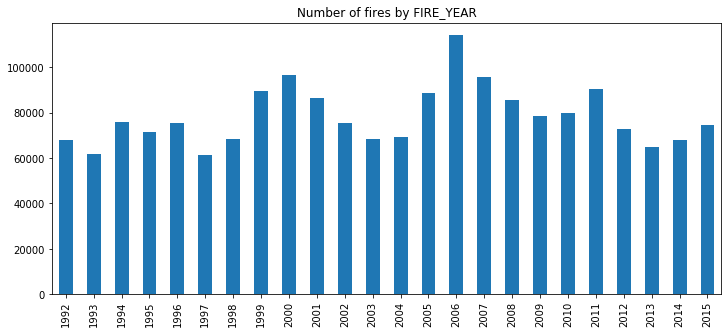

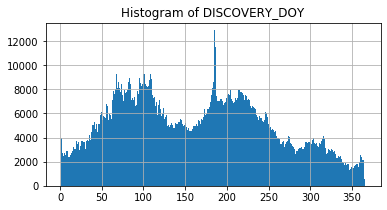

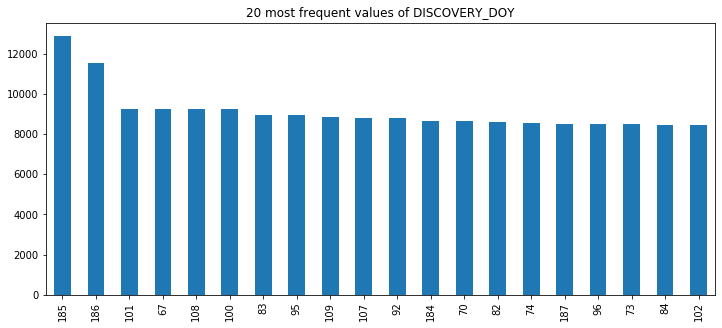

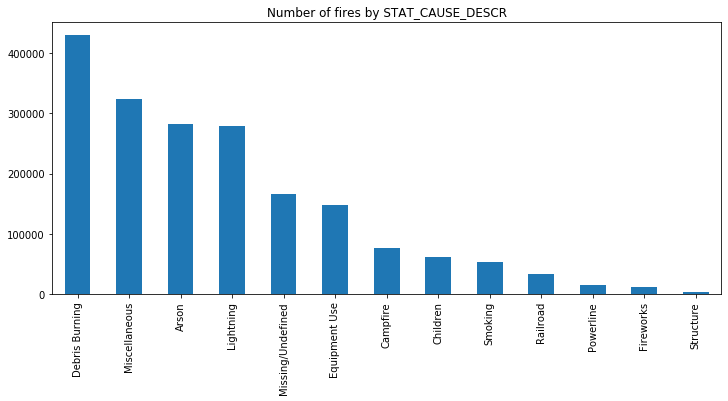

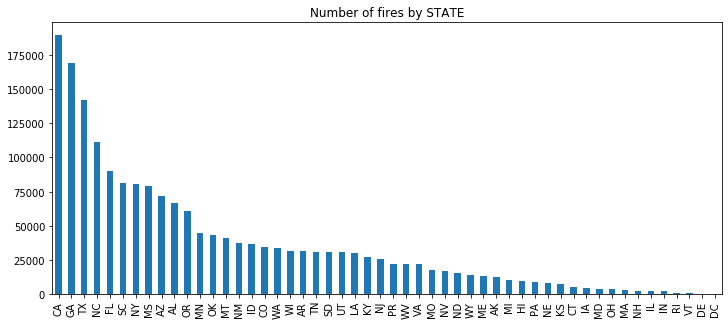

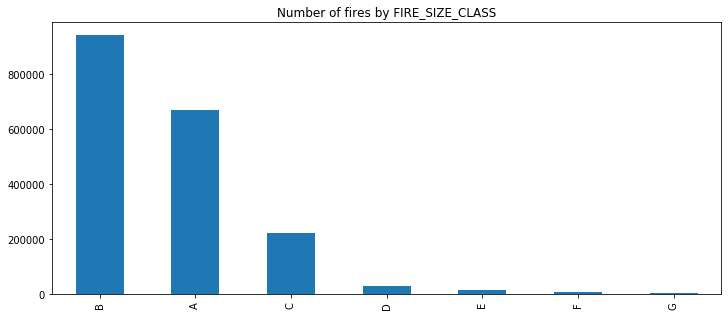

In [19]:
# Columns to study
columns_list = ['FIRE_YEAR','DISCOVERY_DOY', 'STAT_CAUSE_DESCR', 'STATE', 'FIRE_SIZE_CLASS']

for column_name in columns_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    if column_name == 'FIRE_YEAR':
        df[column_name].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
        title="Number of fires by " + column_name
    elif column_name == 'DISCOVERY_DOY':
        df[column_name].hist(bins = 366)
        title="Histogram of " + column_name
        plt.title(title, fontsize=12)
        plt.savefig(os.path.join('wildfire_data', column_name + "_hist_0.png"))
        plt.show()
        df[column_name].value_counts()[:20].plot(kind='bar', figsize=(12,5))
        title="20 most frequent values of " + column_name
    else:
        ax = df[column_name].value_counts().plot(kind='bar', figsize=(12,5))
        title="Number of fires by " + column_name
    plt.title(title, fontsize=12)
    plt.savefig(os.path.join('wildfire_data', column_name + "_hist.png"))
    plt.show()

From the above histogram, we can see a few interesting facts about Wildfires in the US: 
* California is the state with more wildfires from 1992 to 2015. Followed by Georgi and Texas.
* Debris burning is the most common causes. Also from the histogram of causes, we corroborate that the data is highly umbalanced.
* 185 and 186 are the day of the year where more wildfires are discovered, which makes sense as these occur in July month, which is ussually one of the warmest month of the year. 
* 2006 is the year where more Wildfires were discovered. 

Checking the year 2006. TO DO: Why more Wildfires in 2006? 

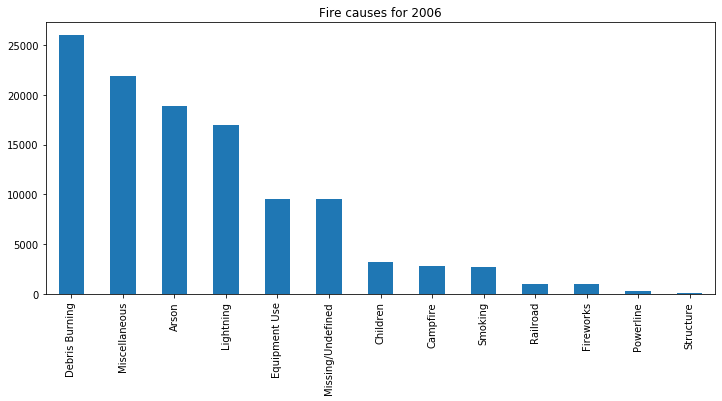

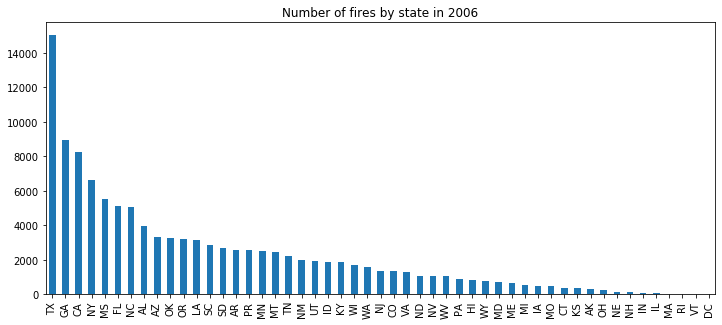

In [20]:
outlier_year = 2006
df['STAT_CAUSE_DESCR'][df['FIRE_YEAR']==outlier_year].value_counts().plot(kind='bar', figsize=(12,5))
plt.title("Fire causes for "+ str(outlier_year), fontsize=12)
plt.show()
df['STATE'][df['FIRE_YEAR']==outlier_year].value_counts().plot(kind='bar', figsize=(12,5))
plt.title("Number of fires by state in "+ str(outlier_year), fontsize=12)
plt.savefig(os.path.join('wildfire_data', "states_2006_hist.png"))
plt.show()

From the graphs above, we can see that wildfire caused by 'Debris burning' happened in [Texas back in 2006](https://www.weather.gov/ama/march2006_wildfire)

Now let's explore the distribution of the fire causes throughout the years. 

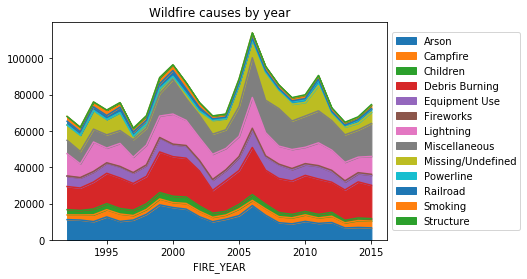

In [39]:
df[['STAT_CAUSE_DESCR', 'FIRE_YEAR']].groupby(['STAT_CAUSE_DESCR', 'FIRE_YEAR']).size().unstack('STAT_CAUSE_DESCR').plot.area(stacked=True);
plt.title("Wildfire causes by year")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Exploring the distribution of the causes throughout the day of the year:

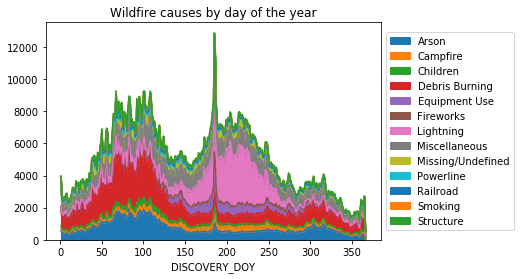

In [38]:
df[['STAT_CAUSE_DESCR', 'DISCOVERY_DOY']].groupby(['STAT_CAUSE_DESCR', 'DISCOVERY_DOY']).size().unstack('STAT_CAUSE_DESCR').plot.area(stacked=True);
plt.title("Wildfire causes by day of the year")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

The causes for each estate. 

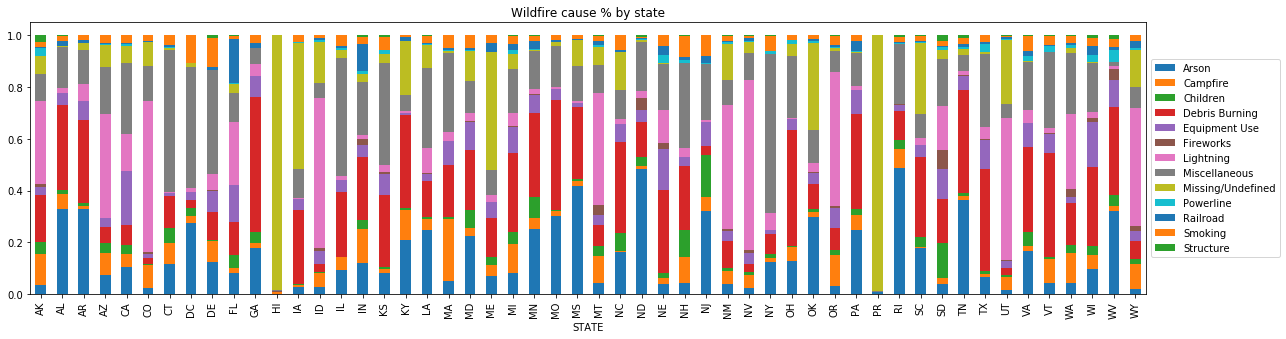

In [45]:
causes_by_state = df[['STAT_CAUSE_DESCR', 'STATE']].groupby(['STAT_CAUSE_DESCR', 'STATE']).size().unstack('STAT_CAUSE_DESCR');
causes_by_state = causes_by_state.div(causes_by_state.sum(1), axis=0)
causes_by_state.plot.bar(stacked = True, figsize = (20, 5))
plt.title("Wildfire cause % by state")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

The above graph confirms that the distribution is very different for each state. 

Now, let's explore the causes depending on the fire size.

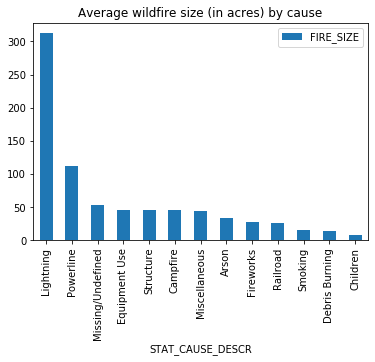

In [52]:
df[['STAT_CAUSE_DESCR', 'FIRE_SIZE']].groupby(['STAT_CAUSE_DESCR']).mean().sort_values('FIRE_SIZE', ascending = False).plot.bar();
plt.title("Average wildfire size (in acres) by cause")
plt.show()

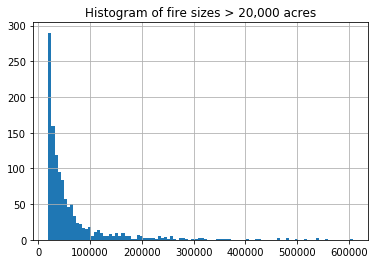

In [62]:
df['FIRE_SIZE'][df['FIRE_SIZE'] > 20000].hist(bins = 100);
plt.title("Histogram of fire sizes > 20,000 acres")
plt.show()

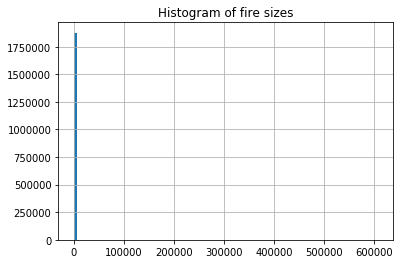

In [63]:
df['FIRE_SIZE'].hist(bins = 100);
plt.title("Histogram of fire sizes")
plt.show()

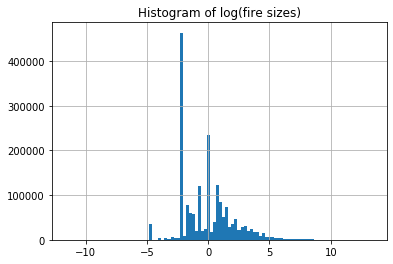

In [64]:
np.log(df['FIRE_SIZE']).hist(bins = 100);
plt.title("Histogram of log(fire sizes)")
plt.show()

The imbalance from classes is confirmed numerically as well. 

In [70]:
df[['STAT_CAUSE_DESCR', 'STAT_CAUSE_CODE']].groupby(['STAT_CAUSE_DESCR', 'STAT_CAUSE_CODE']).size()

STAT_CAUSE_DESCR   STAT_CAUSE_CODE
Arson              7.0                281455
Campfire           4.0                 76139
Children           8.0                 61167
Debris Burning     5.0                429028
Equipment Use      2.0                147612
Fireworks          10.0                11500
Lightning          1.0                278468
Miscellaneous      9.0                323805
Missing/Undefined  13.0               166723
Powerline          11.0                14448
Railroad           6.0                 33455
Smoking            3.0                 52869
Structure          12.0                 3796
dtype: int64

In [68]:
df['FIRE_SIZE'].min()

1e-05